<a href="https://colab.research.google.com/github/sharsulkar/H1B_LCA_outcome_prediction/blob/main/prototyping/notebooks/04_sh_train_predict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np
np.random.seed(42)
import random

In [16]:
#source and encode the output variable
Y=pd.read_excel('https://www.dol.gov/sites/dolgov/files/ETA/oflc/pdfs/LCA_Disclosure_Data_FY2020_Q2.xlsx',usecols=['CASE_STATUS'])
drop_row_index=Y[~Y.CASE_STATUS.isin(['Certified','Denied'])].index
Y.drop(index=drop_row_index, inplace=True)
Y.reset_index(inplace=True,drop=True)
Y.replace(['Certified','Denied'],[0,1],inplace=True)

In [20]:
#check the class distribution 
Y.groupby('CASE_STATUS').size()

CASE_STATUS
0    150011
1      1186
dtype: int64

In [21]:
#Save to drive for future use
Y.to_csv('/content/drive/MyDrive/Datasets/expected.csv')

In [8]:
#import features from saved file 
processed_df=pd.read_csv('/content/drive/MyDrive/Datasets/processed.csv',index_col=0)
processed_df.shape

(151197, 31)

In [44]:
processed_df['CASE_STATUS']=Y
processed_df.to_csv('/content/drive/MyDrive/Datasets/LCA_q2_processed.csv')

In [128]:
processed_df=pd.read_csv('/content/drive/MyDrive/Datasets/LCA_q2_processed.csv',index_col=0)

In [ ]:
processed_df.head()

In [72]:
#algorithm to create mini batches where each batch has a equal distribution of both classes
class_count=2 #number of classes to predict
batch_size=500 #batch size of train+val dataset
val_size=0.2 #validation data % within batch

#collection of indexes for both classes from the entire training dataset
class_0_index=processed_df[processed_df.CASE_STATUS==0].index 
class_1_index=processed_df[processed_df.CASE_STATUS==1].index

In [83]:
def generate_train_val_batches(df,class_0_index,class_1_index,class_count,batch_size,val_size):
  #Generate batches to output training and val data 
  #randomly select indexes of batch size/class_count from the index collection for the entire dataset
  idx_0=random.sample(set(class_0_index.values),int(batch_size/class_count)) 
  idx_1=random.sample(set(class_1_index.values),int(batch_size/class_count))

  #split the indexes into train and val datasets within the selected batch
  split_value=int((batch_size*val_size)/class_count)
  idx_train=idx_0[split_value:]+idx_1[split_value:]
  idx_val=idx_0[:split_value]+idx_1[:split_value]

  #Generate the train and val datasets using the indexes selected in previous step
  X_train=df.loc[idx_train]
  X_val=df.loc[idx_val].reset_index(drop=True)
  y_val=X_val.pop('CASE_STATUS')
  #https://stackoverflow.com/questions/29576430/shuffle-dataframe-rows
  X_train=X_train.sample(frac=1).reset_index(drop=True)
  y_train=X_train.pop('CASE_STATUS')

  return X_train, y_train, X_val, y_val

In [93]:
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier

from sklearn.metrics import accuracy_score


In [94]:
svc=SGDClassifier(loss='hinge')
logistic=SGDClassifier(loss='log')
adaboost=AdaBoostClassifier()
rfc=RandomForestClassifier()

In [169]:
#loop over 
for _ in range(1000):
  X_train, y_train, X_val, y_val=generate_train_val_batches(processed_df,class_0_index,class_1_index,class_count,batch_size,val_size)
  #train classifiers on batches
  for model in [svc,logistic,adaboost,rfc]:
    model.fit(X_train,y_train)
    #print(f1_score(y_true=y_val,y_pred=model.predict(X_val)))


In [158]:
X_test=pd.read_csv('/content/drive/MyDrive/Datasets/LCA_q1_processed.csv',index_col=0)
y_test=pd.read_csv('/content/drive/MyDrive/Datasets/LCA_q1_expected.csv',index_col=0)

In [160]:
y_test.replace(['Certified','Denied'],[0,1],inplace=True)

In [124]:
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt 
from sklearn.metrics import f1_score
%matplotlib inline

In [170]:
print(f1_score(y_true=y_test,y_pred=svc.predict(X_test),average='weighted'))
print(f1_score(y_true=y_test,y_pred=svc.predict(X_test),average=None))
print(f1_score(y_true=y_test,y_pred=adaboost.predict(X_test),average='weighted'))
print(f1_score(y_true=y_test,y_pred=adaboost.predict(X_test),average=None))
print(f1_score(y_true=y_test,y_pred=rfc.predict(X_test),average='weighted'))
print(f1_score(y_true=y_test,y_pred=rfc.predict(X_test),average=None))
print(f1_score(y_true=y_test,y_pred=logistic.predict(X_test),average='weighted'))
print(f1_score(y_true=y_test,y_pred=logistic.predict(X_test),average=None))

0.44328763821778466
[0.44626215 0.01747452]
0.9244972599618939
[0.93037871 0.08254526]
0.5226614782163068
[0.52617444 0.01976753]
0.16888042537669518
[0.16996068 0.01423747]


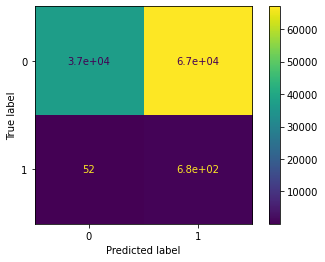

In [171]:
plot_confusion_matrix(rfc,X_test,y_test)

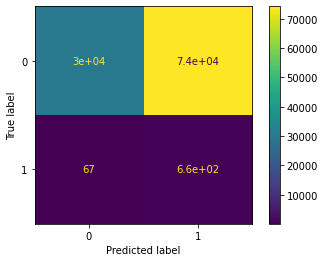

In [172]:
plot_confusion_matrix(svc,X_test,y_test)

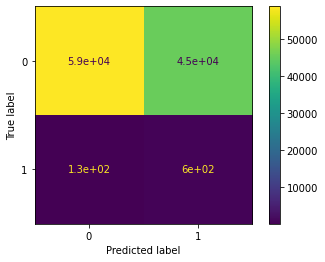

In [167]:
plot_confusion_matrix(adaboost,X_test,y_test)

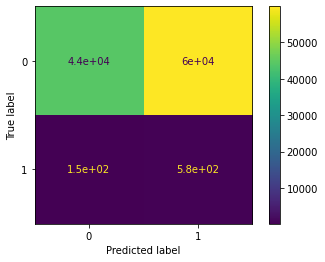

In [168]:
plot_confusion_matrix(logistic,X_test,y_test)